<h1>Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Reading-data" data-toc-modified-id="Reading-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Reading data</a></span></li><li><span><a href="#Matrix-multiplication" data-toc-modified-id="Matrix-multiplication-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Matrix multiplication</a></span></li><li><span><a href="#Transformation-algorithm" data-toc-modified-id="Transformation-algorithm-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Transformation algorithm</a></span></li><li><span><a href="#Algorithm-verification" data-toc-modified-id="Algorithm-verification-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Algorithm verification</a></span></li></ul></div>

# Project description: Protection of customers' personal data

We need to protect the customer data of an insurance company. We will develop a method of data transformation that makes it difficult to recover personal information. We shall justify its correctness.

We need to protect the data so that the quality of machine learning models is not degraded during transformation. There is no need to select the best model.

**Data description**.

- Features: Gender, age and salary of the insured, number of family members.
- Target feature: number of claims paid to the client in the last 5 years.

In [1]:
# importing required libraries 

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import r2_score, mean_squared_error

## Reading data

In [2]:
try:
    df = pd.read_csv('insurance.csv')
    
except FileNotFoundError:
    df = pd.read_csv('/datasets/insurance.csv')
    

**Ознакомимся с данными**

In [3]:
display(df.sample(10), df.info(), df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Пол                5000 non-null   int64  
 1   Возраст            5000 non-null   float64
 2   Зарплата           5000 non-null   float64
 3   Члены семьи        5000 non-null   int64  
 4   Страховые выплаты  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
2737,1,37.0,52400.0,1,0
1083,1,27.0,35000.0,1,0
4530,0,38.0,45000.0,1,0
2649,1,29.0,38800.0,5,0
2674,1,28.0,46200.0,0,0
376,0,36.0,48400.0,2,0
28,1,19.0,36800.0,0,0
1428,0,43.0,27200.0,1,1
2113,0,30.0,52600.0,2,0
682,1,36.0,23400.0,3,0


None

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.360000,1.194200,0.148000
std,0.500049,8.440807,9900.083569,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


- There are 5000 rows in the dataset, no missing values, no problems with data types either.

- There are no strange, inadequate findings related to the data in the descriptive statistics. The rarity of the target feature (Insurance claims) with a value >0 is striking - all of them are in the range below the 3rd quartile and the mean value of the target feature is 0.148


In [4]:
# checking explicit duplicates

df.duplicated().sum()

153

In [5]:
# checking the number of unique values in columns  

df.nunique()

Пол                    2
Возраст               46
Зарплата             524
Члены семьи            7
Страховые выплаты      6
dtype: int64

153 full duplicates were found out of 5000 records, which is 3% of the total dataset. 

However, the variability of our features is not high, due to the specificity of the values represented in them. In addition, we do not have a unique identifying feature such as customer_id, etc. Given the above, we can conclude that the presence of full duplicates is consistent with the logic of the values represented in the dataset, and the presence of full duplicates is more likely a coincidence than an error.

Therefore we do not remove the duplicates, but keep them in their original form.

Analyzing the correlation between the features in the dataset. Will visualize the correlation on a heat map.

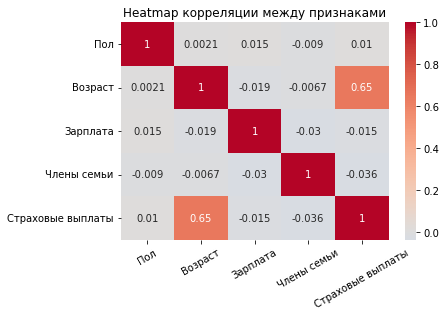

In [6]:
plt.figure()
sns.heatmap(df.corr(), xticklabels=df.corr().columns, yticklabels=df.corr().columns, cmap='coolwarm', center=0, annot=True)
plt.title('Heatmap корреляции между признаками', fontsize=12)
plt.xticks(fontsize=10)
plt.xticks(rotation=30)
plt.yticks(fontsize=10)
plt.show()

The dataset shows a rather strong linear positive correlation between the target feature (Insurance payouts) and age = 0.65. That is, the older the age, the higher the insurance claims. This is likely to be similar to health insurance.

The linear correlation with the other features tends to zero.

**Will visualize the plots by each feature**

***- Gender***

<AxesSubplot:>

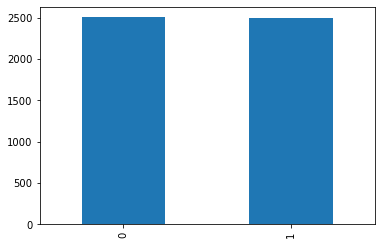

In [7]:
df['Пол'].value_counts().plot.bar()

The gender in the source data is equally distributed. 

***- Age***

<AxesSubplot:xlabel='Возраст', ylabel='Count'>

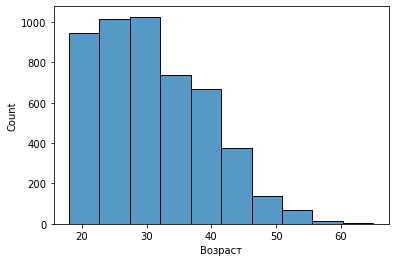

In [8]:
sns.histplot(df['Возраст'], bins=10)

<AxesSubplot:xlabel='Возраст'>

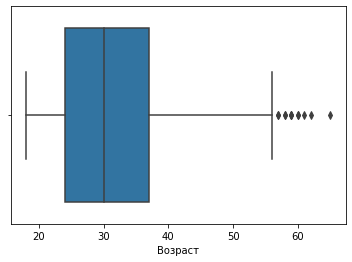

In [9]:
sns.boxplot(df['Возраст'])

The distribution is slightly skewed to the right. In the boxplot, there are few dots behind the right whisker, which is not an outlier but a reflection of the normal nature of the data, which is furthermore confirmed by the equality of the median and the mean value of age.

***- Salary***

<AxesSubplot:xlabel='Зарплата', ylabel='Count'>

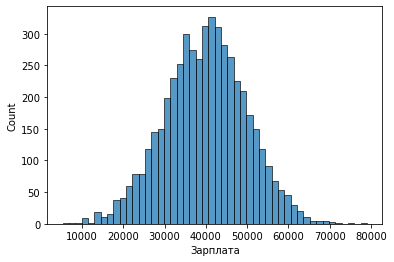

In [10]:
sns.histplot(df['Зарплата'])

<AxesSubplot:xlabel='Зарплата'>

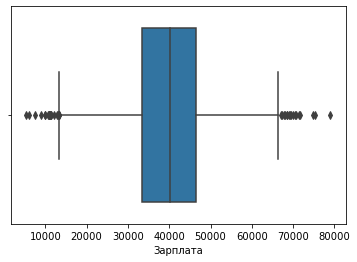

In [11]:
sns.boxplot(df['Зарплата'])

The histogram presents a normal distribution - dome-shaped, with tails in both directions, which is also reflected in the boxplot in the form of black traces outside both whiskers. However, this is also not an outlier, but a reflection of the normal nature of the data in the column, which is also confirmed by the equality of the median and the mean of the wage.

***- Family members***

<AxesSubplot:xlabel='Члены семьи', ylabel='Count'>

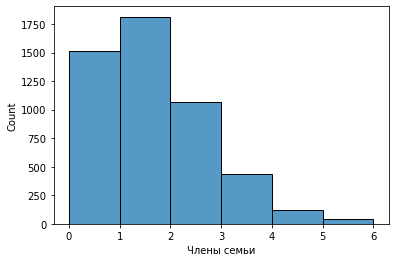

In [12]:
sns.histplot(df['Члены семьи'], bins=6)

<AxesSubplot:xlabel='Члены семьи'>

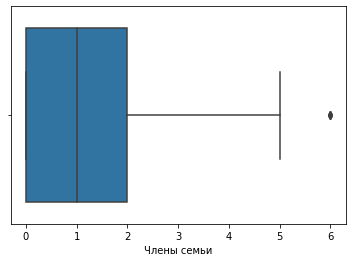

In [13]:
sns.boxplot(df['Члены семьи'])

Also correct distribution of data. Families without children or with one/two children are most common. Families with six children do occur, although this is quite rare. But in any case this is also not an outlier, but a reflection of the normal nature of the data.

***- Insurance payouts***

<AxesSubplot:xlabel='Страховые выплаты', ylabel='Count'>

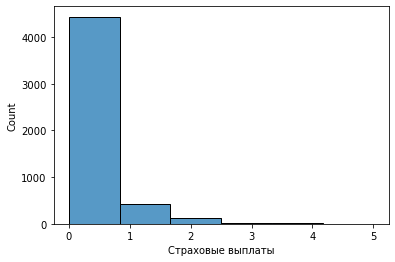

In [14]:
sns.histplot(df['Страховые выплаты'], bins=6)

<AxesSubplot:xlabel='Страховые выплаты'>

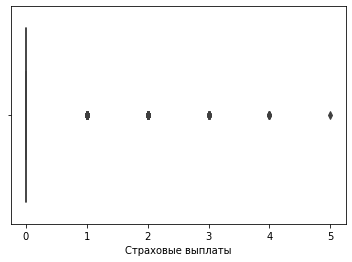

In [15]:
sns.boxplot(df['Страховые выплаты'])

In [16]:
(df['Страховые выплаты']==0).mean()

0.8872

The vast majority of clients (89%) get by without insurance payments. Only 11% of clients are paid insurance payments.

## Matrix multiplication

Introductory formulas:

Predictions:

$$
a = Xw
$$

Learning task:

$$
w = \arg\min_w MSE(Xw, y)
$$

Learning formula:

$$
w = (X^T X)^{-1} X^T y
$$

**Question:** The features are multiplied by a invertible matrix. Will the quality of the linear regression change? 

**Answer:** It won't

**Rationale:**

Notation:

- $X$ - feature matrix (zero column consists of ones)

- $y$ - vector of the target feature

- $P$ - matrix on which the features are multiplied

- $w$ - vector of linear regression weights (zero element equals bias)

The minimum value of MSE is achieved when the weights are calculated using the following formula:

1. $$w = (X^T X)^{-1} X^T y$$

Let $X{'}$ be the new matrix equal to the product of the original feature matrix $X$ by the invertible matrix $P$: 

2. $$X{'} = X P$$

Let's substitute this product into the formula to calculate the new vector of linear regression weights:

3. $$ w{'} = (X{'}^T X{'})^{-1} X{'}^T y$$

4. $$ w{'} = ((X P)^T X P)^{-1} (X P)^T y$$

Given that $(AB)^T = B^T A^T$, represent the expression as follows:

5. $$ w{'} = (P^T X^T X P)^{-1} P^T X^T y$$

Given that $(AB)^{-1} = B^{-1}A^{-1}$, represent the expression as follows:

6. $$ w{'} = P^{-1} (X^T X)^{-1} (P^T)^{-1} P^T X^T y$$

Given that the matrix $P$ is inversible, its product of the inverse matrix equals the unit matrix, i.e. $(P^T)^{-1} P^T$ equals the unit matrix $E$. Let's substitute:

7. $$ w{'} = P^{-1} (X^T X)^{-1} E X^T y = P^{-1} (X^T X)^{-1} X^T y$$

Note that the part of the formula following the matrix $P^{-1}$ is a formula for calculating the initial vector of weights $w$ (see point 1). Let us substitute and rewrite the formula accordingly:

8. $$ w{'} = P^{-1} w$$

The formula for calculating the prediction vector of the original model is as follows:

9. $$ a = Xw $$

The formula for calculating the prediction vector of the new model would then look as follows:

$$ a{'} = X{'}w{'} = XP P^{-1} w$$

Given that the matrix $P$ is inversible, its product by the inverse matrix equals the unit matrix, i.e. $PP^{-1}$ equals the unit matrix $E$. Let's substitute:

$$ a{'} = XP P^{-1} w = XEw = Xw$$ 

Since the product of the original feature matrix by the original feature weight vector - $Xw$ - is equal to the prediction vector of the original model $a$ (see point 9), respectively

$$a{'} = a$$

Thus, we have proved that the predictions for the transformed matrix with new features $a{'}$ obtained by multiplying the original feature matrix $X$ by the invertible matrix $P$ are equal to the predictions for the matrix with original features $a$.

That is, the quality of the linear regression will not change, as the quality of the model is derived from the predictions (which are the same before and after transformations) and the target feature, which are fed into the input when calculating the quality metrics of the model.

The parameters of the linear regression in the original problem and in the transformed one are related as follows:

$$ w{'} = P^{-1} w$$

## Transformation algorithm

**Algorithm**.

In order to protect the data and preserve the quality of the machine learning model, the features of the original matrix will be multiplied by a invertible matrix: $X{'} = X P$

To do this, the data transformation algorithm must contain a process of creating a such random matrix and multiplying it by the feature matrix.

**Rationale**.

As was mathematically proven in the previous step, the model predictions for the transformed feature matrix are the same as those for the matrix with the original features (before transformation). Thus, the transformations will not change the quality of the model, since the model quality metrics is calculated based on the predictions and target feature values, which are the same in both cases (before and after the transformations). Accordingly, the values of the metrics will also coincide. 

Let us prove our theoretical justification by calculations.

## Algorithm verification

In order to test the algorithm, let us calculate the vectors of predictions of the target feature before and after the transformations, that is, vector $a$ and $a'$, respectively. 

First, let us define the initial features and the target feature.

In [17]:
features = df.drop('Страховые выплаты', axis=1)
target = df['Страховые выплаты']

Scaling the features with `StandardScaler()`

In [18]:
scaler = StandardScaler()
scaler.fit(features)

features = scaler.transform(features)

Will calculate the prediction vector for the original feature matrix using the formula: $ a = Xw $.

Accordingly, first will calculate the vector of weights for the features of the original matrix by the formula: $w = (X^T X)^{-1} X^T y$. 

In [19]:
# calculating the vector of weights for the features of the original matrix

w = np.linalg.inv(features.T @ features) @ features.T @ target

# calculating the predictions vector for the original features matrix

a = features @ w

Next, calculate the predictions vector for the transformed feature matrix using the formula $ a{'} = X{'}w{'}$.

Accordingly, the vector of weights for the features of the transformed matrix by the formula $ w{'} = (X{'}^T X{'})^{-1} X{'}^T y$.

Our transformation algorithm must contain the process of forming a inverse matrix, in order to multiply it by the original feature matrix. 

The inversible matrix must be square with such a dimension that after multiplication we get a matrix with the size of our initial matrix of features (5000,4). That is, the inverse matrix $P$ must be of dimension (4,4). When (5000,4)x(4,4) is multiplied, the internal dimensions "collapse" and we get a matrix of dimension (5000,4).

In [20]:
# creating a randomly inversible square matrix P for the subsequent transformation of the original feature matrix

P = np.random.randint(1000, size=(features.shape[1], features.shape[1]))
P

array([[861, 786, 332, 968],
       [291, 606, 982, 523],
       [943, 577, 172, 258],
       [613,  58, 668, 233]])

Check the matrix for inversability.

In [21]:
np.linalg.inv(P)

array([[-3.78587394e-06, -7.46202781e-04,  6.96433693e-04,
         9.19523122e-04],
       [-5.95289984e-04,  1.26750732e-03,  1.40677557e-03,
        -1.92967262e-03],
       [-5.39484522e-04,  7.97607870e-04, -1.66682303e-04,
         6.35519894e-04],
       [ 1.70482069e-03, -6.39035094e-04, -1.70456248e-03,
         5.31013086e-04]])

Transform the original feature matrix by multiplying it with the inverse matrix P.

In [22]:
features_p = features @ P

Calculating the vector of weights for the features of the transformed matrix using the formula $ w{'} = (X{'}^T X{'})^{-1} X{'}^T y$ and respectively the vector of predictions for the transformed features matrix by the formula $ a{'} = X{'}w{'}$.

In [23]:
# Calculating the vector of weights for the features of the transformed matrix 

w_p = np.linalg.inv(features_p.T @ features_p) @ features_p.T @ target

# Calculating the vector of predictions for the transformed features matrix

a_p = features_p @ w_p

We have obtained two predictions vectors, for the original and transformed matrices. To ensure that they are equal, their difference must be equal or tend to zero.

In [24]:
# Calculating the difference between the original and transformed predictions vectors

diff = a - a_p
diff[:10]

array([ 4.38538095e-15,  7.66053887e-15, -1.74166237e-15, -1.55431223e-15,
       -6.49480469e-15, -1.33226763e-15, -3.27515792e-15, -1.41553436e-14,
        3.08086889e-15,  2.47718512e-15])

Each of the first 10 resulting values tends to zero. Will check that this is true for all 5000 values of our difference vector. If each value tends to zero, then the sum of all values must also tend to zero.

In [25]:
diff.sum()

-4.621303340002214e-14

This is the case - the sum tends to zero. We have confirmed the fact that the predictions for the matrix with the original features are the same as those for the matrix with the transformed features, that is, $a = a'$.

Let us check that the quality of the linear regression does not differ before and after the transformation. Let us assess the quality of the models by MSE and R2 metrics.

In [26]:
# checking the quality of Linear Regression model on original data

model = LinearRegression()
model.fit(features, target)
predictions = model.predict(features)
print('MSE Score:', mean_squared_error(target, predictions))
print('R2_Score на исходных данных:', r2_score(target, predictions))

MSE Score: 0.12334688941710859
R2_Score на исходных данных: 0.4249455028666801


In [27]:
# checking the quality of Linear Regression model on transformed data

model = LinearRegression()
model.fit(features_p, target)
predictions = model.predict(features_p)
print('MSE Score:', mean_squared_error(target, predictions))
print('R2_Score на исходных данных:', r2_score(target, predictions))

MSE Score: 0.12334688941710859
R2_Score на исходных данных: 0.4249455028666801


**Conclusion:**

The calculations show that the quality metrics of the models on the original and transformed data are the same. Thus we can conclude that we have succeeded in developing an algorithm to protect insurance company customers' data without losing the quality of the machine learning models. 